In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import nelpy as nel
import numpy as np
import matplotlib.pyplot as plt
from ripple_heterogeneity.utils import loading, functions
import statistics
from nelpy.auxiliary import _position


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [10]:
basepath = r"Z:\Data\AYAold\AYA7\day20"
# basepath = r"Z:\Data\AYAold\AB3\AB3_58_59"
basepath = r"Z:\Data\AYAold\AYA7\day24"
basepath = r"Z:\Data\HMC1\day13"
beh_df = loading.load_animal_behavior(basepath)

if np.isnan(beh_df.linearized).all():
    x, y = functions.linearize_position(beh_df.x,beh_df.y)
    beh_df.linearized = x  
    
pos = nel.AnalogSignalArray(
    data=np.array(beh_df.linearized),
    timestamps=beh_df.time,
    fs=1 / statistics.mode(np.diff(beh_df.time)),
)


c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


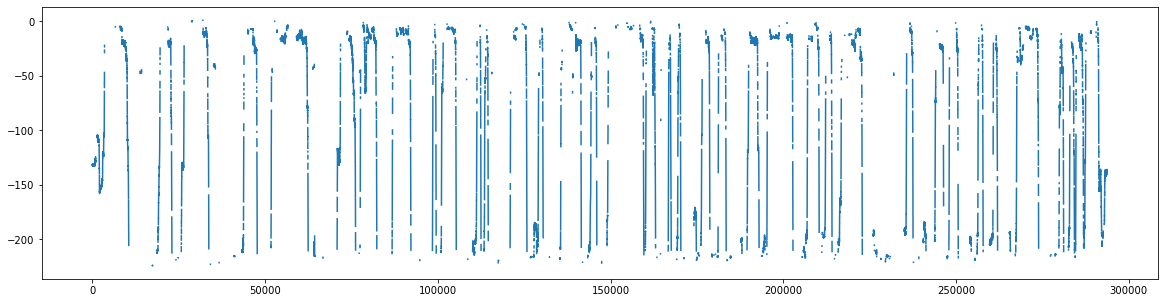

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(beh_df.x)


# cubic spline and code from deeplabcut

In [5]:
from scipy.interpolate import CubicSpline

def columnwise_spline_interp(data, max_gap=0):
    """
    Perform cubic spline interpolation over the columns of *data*.
    All gaps of size lower than or equal to *max_gap* are filled,
    and data slightly smoothed.
    Parameters
    ----------
    data : array_like
        2D matrix of data.
    max_gap : int, optional
        Maximum gap size to fill. By default, all gaps are interpolated.
    Returns
    -------
    interpolated data with same shape as *data*
    """
    if np.ndim(data) < 2:
        data = np.expand_dims(data, axis=1)
    nrows, ncols = data.shape
    temp = data.copy()
    valid = ~np.isnan(temp)
    x = np.arange(nrows)
    for i in range(ncols):
        mask = valid[:, i]
        if (
            np.sum(mask) > 3
        ):  # Make sure there are enough points to fit the cubic spline
            spl = CubicSpline(x[mask], temp[mask, i])
            y = spl(x)
            if max_gap > 0:
                inds = np.flatnonzero(np.r_[True, np.diff(mask), True])
                count = np.diff(inds)
                inds = inds[:-1]
                to_fill = np.ones_like(mask)
                for ind, n, is_nan in zip(inds, count, ~mask[inds]):
                    if is_nan and n > max_gap:
                        to_fill[ind : ind + n] = False
                y[~to_fill] = np.nan
            # Get rid of the interpolation beyond the spline knots
            y[y == 0] = np.nan
            temp[:, i] = y
    return temp

In [ ]:
plt.figure(figsize=(20, 5))

x = columnwise_spline_interp(beh_df.x.values, max_gap=int(1 / statistics.mode(np.diff(beh_df.time)))*2)
plt.plot(beh_df.time,x,color="k")
plt.plot(beh_df.time,beh_df.x,color="pink")

plt.figure(figsize=(20, 5))
plt.plot(beh_df.time,x,color="k")
plt.plot(beh_df.time,beh_df.x,color="pink")
plt.xlim([9600,10200])

# using pandas to call scipy interpolate 

linear interp with 5 seconds max

(10500.0, 11000.0)

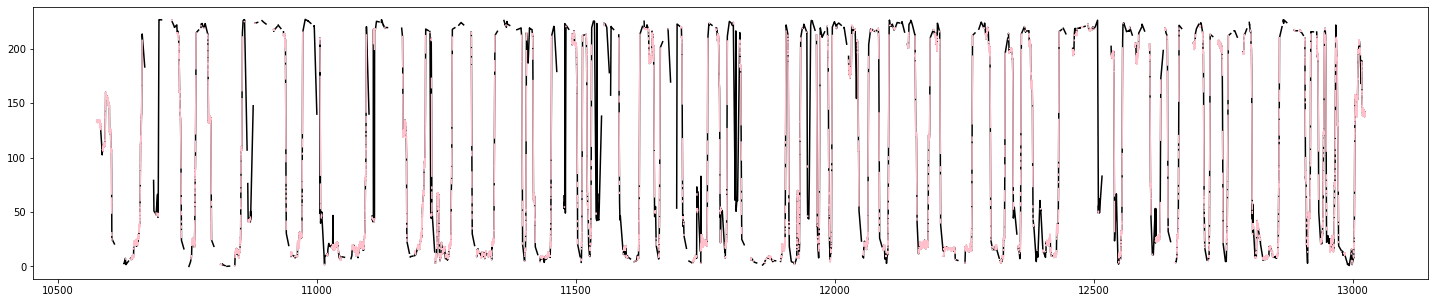

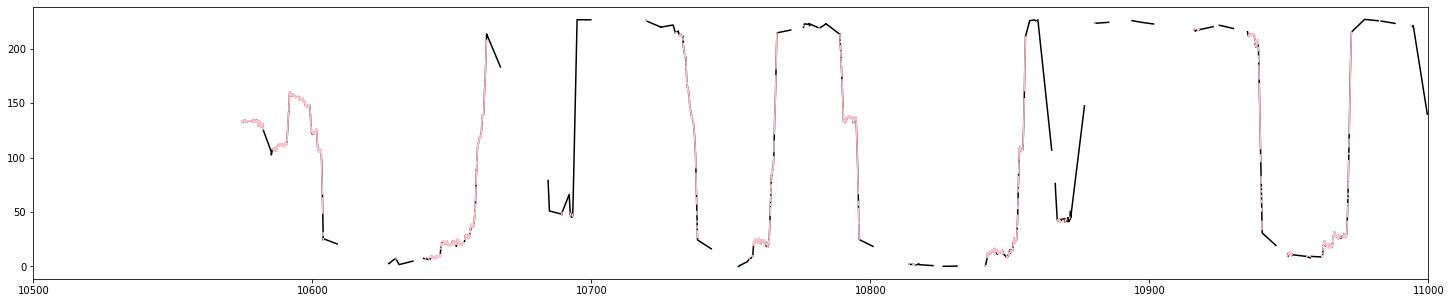

In [13]:
plt.figure(figsize=(25, 5))
x = beh_df.linearized.interpolate(
        method="linear",
        limit=int(1 / statistics.mode(np.diff(beh_df.time)))*5,
    )
# x[(x < np.nanmin(beh_df.linearized.values)) & (x > np.nanmax(beh_df.linearized.values))] = np.nan

plt.plot(beh_df.time,x,color="k",)
plt.plot(beh_df.time,beh_df.linearized,color="pink")

plt.figure(figsize=(25, 5))
plt.plot(beh_df.time,x,color="k")
plt.plot(beh_df.time,beh_df.linearized,color="pink")
plt.xlim([10500,11000])

In [17]:
outbound_epochs, inbound_epochs = functions.get_linear_track_lap_epochs(
    beh_df.time,
    x,
    newLapThreshold=15,
    good_laps=False,
    edgethresh=0.1,
    completeprop=0.2,
    posbins=50,
)
outbound_epochs, inbound_epochs

(<EpochArray at 0x265c23fd220: 37 epochs> of length 17:54:595 minutes,
 <EpochArray at 0x265c23fdb80: 37 epochs> of length 22:41:830 minutes)

In [21]:
pos = nel.AnalogSignalArray(data=x.values, timestamps=beh_df.time, fs=1 / statistics.mode(np.diff(beh_df.time)))

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


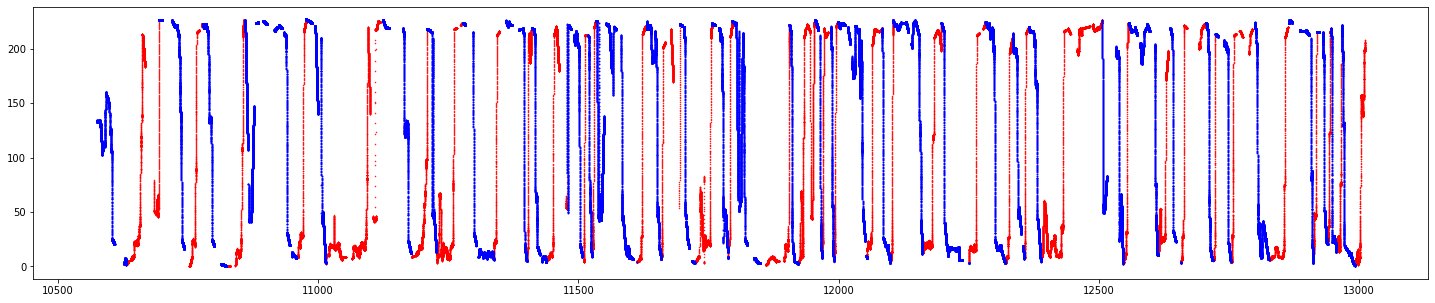

In [34]:
plt.figure(figsize=(25, 5))
plt.plot(pos[outbound_epochs].abscissa_vals,pos[outbound_epochs].data.T,".r",markersize=1)
plt.plot(pos[inbound_epochs].abscissa_vals,pos[inbound_epochs].data.T,".b",markersize=2)

In [56]:
beh_df.linearized = beh_df.linearized.interpolate(
    method="cubicspline",
    order=2,
    limit=int(1 / statistics.mode(np.diff(beh_df.time))) * 2,
)


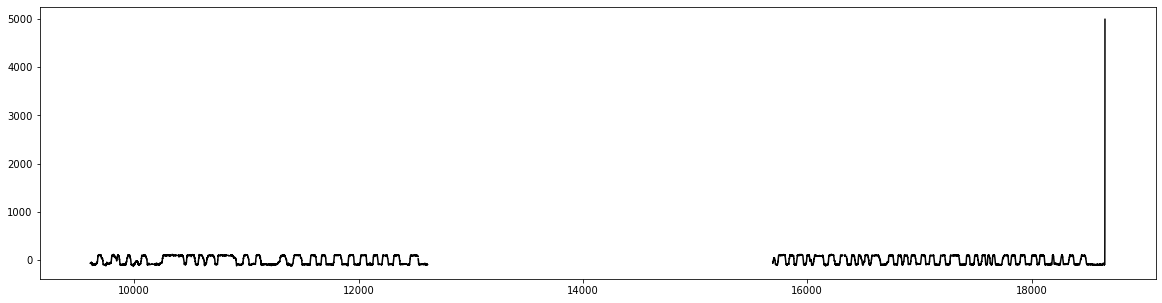

In [57]:
plt.figure(figsize=(20, 5))

plt.plot(beh_df.time,beh_df.linearized,color="k")


In [58]:
# pos = nel.AnalogSignalArray(
#     data=np.array(beh_df.linearized),
#     timestamps=beh_df.time,
#     fs=1 / statistics.mode(np.diff(beh_df.time)),
# )
# pos = _position.PositionArray(np.array(beh_df.linearized).T,
#                     abscissa_vals=beh_df.time,
#                     fs=1 / statistics.mode(np.diff(beh_df.time)))

pos = _position.PositionArray(pos)
